###### Funtions from class


In [1]:
def clean_text(str_in):
    import re
    tmp = re.sub("[^A-Za-z'0-9]+", " ",str_in).lower().strip().replace("  ", " ")
    return tmp

def rem_sw(var_in):
    from nltk.corpus import stopwords
    sw = stopwords.words("english")
    sw.remove('no')
    sw.remove('not')
    tmp = var_in.split()
    # tmp_ar = list()
    # for word_t in tmp:
    #     if word_t not in sw:
    #         tmp_ar.append(word_t)
    tmp_ar = [word_t for word_t in tmp if word_t not in sw]
    tmp_o = ' '.join(tmp_ar)
    return tmp_o

# -*- coding: utf-8 -*-
"""
Created on Mon Feb 13 18:43:11 2023

@author: pathouli
"""

def clean_text(str_in):
    import re
    tmp = re.sub("[^A-Za-z'0-9]+", " ",str_in).lower().strip().replace("  ", " ")
    return tmp

def file_clean(path_in):
    f = open(path_in, encoding="UTF-8")
    tmp = f.read()
    f.close()
    tmp = clean_text(tmp)
    return tmp

def read_files(path_in):
    import os
    import pandas as pd
    file_list = pd.DataFrame()
    for root, dirs, files in os.walk(path_in, topdown=False):
        for name in files:
            try:
                t_path = root + "/" + name
                file_p = file_clean(t_path)
                t_p = root.split("/")[-1:][0]
                if len(file_p) > 0:
                    file_list = file_list.append(
                        {"body": file_p, "label": t_p
                         }, ignore_index=True)
            except:
                print (t_path)
                pass
    return file_list

def wrd_dictionary(df_in, col_name_in):
    import collections
    my_dictionaty_t = dict()
    for topic_t in df_in.label.unique():
        tmp = df_in[df_in.label == topic_t]
        tmp = tmp[col_name_in].str.cat(sep=" ")
        wrd_freq = collections.Counter(tmp.split())
        my_dictionaty_t[topic_t] = wrd_freq
    return my_dictionaty_t

def rem_sw(var_in):
    from nltk.corpus import stopwords
    sw = stopwords.words("english")
    tmp = var_in.split()
    # tmp_ar = list()
    # for word_t in tmp:
    #     if word_t not in sw:
    #         tmp_ar.append(word_t)
    tmp_ar = [word_t for word_t in tmp if word_t not in sw]
    tmp_o = ' '.join(tmp_ar)
    return tmp_o

def write_pickle(obj_in, path_in, name_in):
    import pickle
    pickle.dump(obj_in, open(path_in + name_in + ".pk", 'wb'))
    
def read_pickle(path_in, name_in):
    import pickle
    the_data_t = pickle.load(open(path_in + name_in + ".pk", 'rb'))
    return the_data_t

def wrd_cnt(txt_in):
    tmp = len(set(txt_in.split()))
    return tmp

def stem_fun(txt_in):
    from nltk.stem import PorterStemmer
    stem_tmp = PorterStemmer()
    tmp = [stem_tmp.stem(word) for word in txt_in.split()]
    tmp = ' '.join(tmp)
    # tmp = list()
    # for word in txt_in.split():
    #     tmp.append(stem_tmp.stem(word))
    return tmp

def bag_of_words(texts):
  word_count = {}
  for text in texts:
    for word in text.split():
      if word in word_count:
        word_count[word] += 1
      else:
        word_count[word] = 1
  
  df = pd.DataFrame.from_dict(word_count, orient='index', columns=['frequency'])
  df.sort_values(by='frequency', ascending=False, inplace=True)
  return df



#### Import packages and data

In [161]:
import pandas as pd
import numpy as np
import os
from top2vec import Top2Vec

In [28]:
#Reading in database
opinions = pd.read_csv(r'C:\Users\tahas\Documents\QMSS\NPL class\all_opinions.csv')
docs = opinions.text[opinions['author_name'] == 'Justice Thomas'].tolist()

#### general overview of data

C:\Users\tahas\AppData\Local\Temp\ipykernel_24388\2021026314.py:7: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\tahas\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\tahas\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



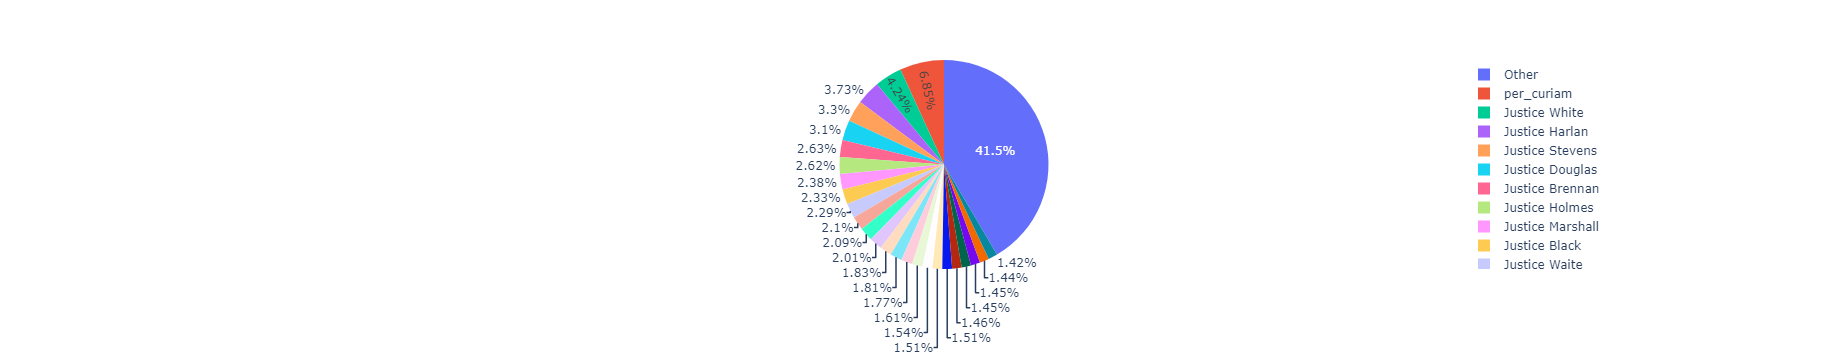

In [215]:
import matplotlib.pyplot as plt
author_name_counts = opinions['author_name'].value_counts()

labels = []
sizes = []

for name, count in author_name_counts.iteritems():
    if count < 500:
        labels.append("Other")
        sizes.append(count)
    else:
        labels.append(name)
        sizes.append(count)

pie = pd.concat([pd.DataFrame(labels, columns = ['name']),pd.DataFrame(sizes, columns = ['count'])], axis =1)
# pie = pie.groupby('name').sum()
# pie = pie.reset_index()

import plotly.express as px

fig = px.pie(pie, values='count', names='name')
fig.show()


## Using LDA from Gensim

In [275]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

import spacy
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.gensim

Lemmatize the text:

Lemmatization is a process of grouping together different inflected forms of a word so they can be analysed as a single item. This is done by reducing inflected (or sometimes derived) words to their word stem, base or root, generally known as the lemma. For example, the lemma of the word 'studying', is 'study'. Lemmatization is typically used to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. It is used to improve the accuracy of search engine results, text analytics, and other NLP tasks.

In [291]:

def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)
    
lem_text = lemmatization(docs)


Remove stopwords and a few custom words from lemmatized text

In [296]:
def rem_sw(var_in):
    from nltk.corpus import stopwords
    sw = stopwords.words("english")
    sw.extend(['see','file','hold','use','only','also','other','make','I'])
    sw.remove('no')
    sw.remove('not')
    tmp = var_in.split()
    # tmp_ar = list()
    # for word_t in tmp:
    #     if word_t not in sw:
    #         tmp_ar.append(word_t)
    tmp_ar = [word_t for word_t in tmp if word_t not in sw]
    tmp_o = ' '.join(tmp_ar)
    return tmp_o 

docs_clean = [rem_sw(text) for text in lem_text]

###### Make a bag of words to review work frequency

In [299]:
bag_of_words(docs_clean)[0:10]

,frequency
court,6787
law,5934
state,5709
case,5636
claim,4364
right,3537
federal,3472
statute,3237
rule,2833
supra,2795


##### Use gensim preprocesssing pipeline to remove symbos and whatever else it does lol

In [163]:
# preprocesses the words to take out stopwords and remove accent marks
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return final
    
data_words = gen_words(lem_text)

##### Make bi-grams and tri-grams to get at phrases

In [343]:
#Bigrams and Trigrams
bigram_phrases = gensim.models.Phrases(data_words, min_count = 5, threshold=50)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=50)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigram(texts):
    return(bigram[doc] for doc in texts)

def make_trigram(texts):
    return(trigram[bigram[doc]] for doc in texts)

data_bigrams = make_bigram(data_words)
data_bigrams_trigrams = make_trigram(data_bigrams)

In [344]:
data_bigrams_trigrams_list = []
for phrase in data_bigrams_trigrams:
    data_bigrams_trigrams_list.append(phrase)

In [354]:
data_bigrams_trigrams_list[1]

['concur',
 'stress',
 'sexual_harassment',
 'case',
 'plaintiff',
 'plead',
 'ultimately',
 'prove',
 'statutory',
 'requirement',
 'discrimination',
 'sex']

In [357]:
from gensim.models import TfidfModel
id2word = corpora.Dictionary(data_bigrams_trigrams_list)
texts = data_bigrams_trigrams_list
corpus = [id2word.doc2bow(text) for text in texts]

In [361]:
from gensim.models import TfidfModel
id2word = corpora.Dictionary(data_bigrams_trigrams_list)
texts = data_bigrams_trigrams_list
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)
low_value = 0.03
words = []
words_missing_in_tfidf = []

for i in range(0,len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids=[id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value<low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops: 
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 4), (11, 1), (12, 1), (13, 1), (14, 6), (15, 4), (16, 1), (17, 2), (18, 1), (19, 1)]


In [364]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics = 10,
                                            update_every = 1,
                                            chunksize=100,
                                            passes=10,
                                            alpha="auto")

In [366]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model,corpus,id2word, mds="mmda",R=30)
vis

C:\Users\tahas\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.118754  0.244111       1        1  15.722823
1     -0.138898  0.146310       2        1  14.997959
4      0.238670  0.024614       3        1  12.450312
3     -0.076507 -0.015187       4        1  11.241881
7      0.263239 -0.141359       5        1   9.047345
8     -0.056921  0.069814       6        1   8.432382
2     -0.089296  0.117990       7        1   8.355673
9     -0.072007 -0.152614       8        1   7.963616
6     -0.045958 -0.172446       9        1   5.908632
5     -0.141076 -0.121234      10        1   5.879376, topic_info=                Term         Freq        Total Category  logprob  loglift
1126           state  2678.000000  2678.000000  Default  30.0000  30.0000
174              law  2145.000000  2145.000000  Default  29.0000  29.0000
75             court  1629.000000  1629.000000  Default  28.0000  28.0000
50             claim  2754.000000  2754.000000  Default  27.0000  27.0000
1717           trial  1241.000000  1241.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
1236             bar    81.942597   265.219572  Topic10  -5.1957   1.6592
1101            sale    80.537154   255.689028  Topic10  -5.2130   1.6785
938   interpretation    78.300044   283.013603  Topic10  -5.2412   1.5488
113         evidence    77.051781   832.669311  Topic10  -5.2572   0.4536
483       petitioner    76.545425  1696.399969  Topic10  -5.2638  -0.2647

[606 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4366      1  0.982777  abortion
2210      4  0.960650    access
2210      7  0.034933    access
3         1  0.059193       act
3         2  0.939370       act
...     ...       ...       ...
4605      3  0.990634   witness
1197      8  0.998160      work
3006      3  0.995181      writ
666       1  0.986948     write
3473      4  0.980603  year_old

[1001 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 4, 8, 9, 3, 10, 7, 6])